# PCOP Analysis

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import os
from datasets import load_from_disk, DatasetDict
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from transformers import PreTrainedModel, PretrainedConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import AutoConfig

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
script_dir = os.path.abspath('')
dataset_folder = os.path.join(script_dir, "../../datasets/PCOP/data")
annotations_folder = os.path.join(script_dir, "../../datasets/PCOP")
output_folder = os.path.join(script_dir, "../../datasets/PCOP")

In [6]:
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")

In [7]:
dataset = load_from_disk(annotations_folder)

In [8]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)
train_test_split = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']
})
train_test_split.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [9]:
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    return {"input_ids": input_ids, "attention_mask": attention_mask}, labels

In [10]:
train_loader = DataLoader(train_test_split['train'], batch_size=8, collate_fn=collate_fn)
test_loader = DataLoader(train_test_split['test'], batch_size=8, collate_fn=collate_fn)

In [11]:
class HerBERTForMultiLabelClassification(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.herbert = AutoModelForSequenceClassification.from_pretrained("allegro/herbert-base-cased", config=config)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,
    ):
        outputs = self.herbert(input_ids=input_ids, attention_mask=attention_mask)
        
        logits = outputs.logits
        
        loss = None
        if labels is not None:
            loss_fct = torch.nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.float().view(-1, self.num_labels))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [12]:
num_classes = len(dataset['labels'][0][0])

In [13]:
config = AutoConfig.from_pretrained("allegro/herbert-base-cased")
config.num_labels = num_classes

# Initialize the model
model = HerBERTForMultiLabelClassification.from_pretrained(
    "allegro/herbert-base-cased",
    config=config
).to(device)

C:\Users\arkad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of HerBERTForMultiLabelClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['herbert.bert.embeddings.LayerNorm.bias', 'herbert.

In [14]:
optimizer = AdamW(model.parameters(), lr=5e-5)

C:\Users\arkad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
train_losses = []
test_losses = []
test_f1_scores = []

model_save_dir = "saved_models"
os.makedirs(model_save_dir, exist_ok=True)

for epoch in range(3):  # Example epoch count
    model.train()
    total_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Logging for each batch
        if batch_idx % 10 == 0:  # Log every 10 batches
            print(f"Epoch: {epoch + 1}, Batch: {batch_idx}, Loss: {loss.item()}")
            batch_save_path = os.path.join(model_save_dir, f"epoch_{epoch + 1}.pt")
            torch.save(model.state_dict(), batch_save_path)
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Average Training Loss at Epoch {epoch + 1}: {avg_train_loss}")

    # Evaluation loop
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            outputs = model(**inputs, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()

    avg_test_loss = total_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Average Validation Loss at Epoch {epoch + 1}: {avg_test_loss}")

Epoch: 1, Batch: 0, Loss: 0.7015587091445923
Epoch: 1, Batch: 10, Loss: 0.5278341174125671
Epoch: 1, Batch: 20, Loss: 0.40939566493034363
Epoch: 1, Batch: 30, Loss: 0.3051389157772064
Epoch: 1, Batch: 40, Loss: 0.2334408015012741
Epoch: 1, Batch: 50, Loss: 0.17955203354358673
Epoch: 1, Batch: 60, Loss: 0.14155268669128418
Epoch: 1, Batch: 70, Loss: 0.10849737375974655
Epoch: 1, Batch: 80, Loss: 0.09820429235696793
Epoch: 1, Batch: 90, Loss: 0.09147662669420242
Epoch: 1, Batch: 100, Loss: 0.08891666680574417
Epoch: 1, Batch: 110, Loss: 0.0731179416179657
Epoch: 1, Batch: 120, Loss: 0.07221600413322449
Epoch: 1, Batch: 130, Loss: 0.05765093117952347
Epoch: 1, Batch: 140, Loss: 0.06846106052398682
Epoch: 1, Batch: 150, Loss: 0.06881045550107956
Epoch: 1, Batch: 160, Loss: 0.0638841837644577
Epoch: 1, Batch: 170, Loss: 0.07177113741636276
Epoch: 1, Batch: 180, Loss: 0.07121806591749191
Epoch: 1, Batch: 190, Loss: 0.06269090622663498
Epoch: 1, Batch: 200, Loss: 0.058961499482393265
Epoch: 1

Epoch: 3, Batch: 490, Loss: 0.053408414125442505
Epoch: 3, Batch: 500, Loss: 0.07166799157857895
Epoch: 3, Batch: 510, Loss: 0.054046813398599625
Epoch: 3, Batch: 520, Loss: 0.05199276655912399
Epoch: 3, Batch: 530, Loss: 0.04696369543671608
Epoch: 3, Batch: 540, Loss: 0.04021221399307251
Epoch: 3, Batch: 550, Loss: 0.05244966968894005
Epoch: 3, Batch: 560, Loss: 0.04282807186245918
Epoch: 3, Batch: 570, Loss: 0.042078256607055664
Epoch: 3, Batch: 580, Loss: 0.04766971617937088
Average Training Loss at Epoch 3: 0.05096968320576956
Average Validation Loss at Epoch 3: 0.051033896623715144


In [20]:
loss_values = [
    0.7015587091445923, 0.5278341174125671, 0.40939566493034363, 0.3051389157772064, 0.2334408015012741,
    0.17955203354358673, 0.14155268669128418, 0.10849737375974655, 0.09820429235696793, 0.09147662669420242,
    0.08891666680574417, 0.0731179416179657, 0.07221600413322449, 0.05765093117952347, 0.06846106052398682,
    0.06881045550107956, 0.0638841837644577, 0.07177113741636276, 0.07121806591749191, 0.06269090622663498,
    0.058961499482393265, 0.06551320105791092, 0.05547435209155083, 0.049694716930389404, 0.052042990922927856,
    0.06804904341697693, 0.042582932859659195, 0.049016691744327545, 0.05124348774552345, 0.03256359323859215,
    0.042120546102523804, 0.05121053755283356, 0.07234982401132584, 0.06737739592790604, 0.04988103732466698,
    0.040515653789043427, 0.07138007134199142, 0.05199138820171356, 0.05603331699967384, 0.04044143855571747,
    0.0506027452647686, 0.04384293779730797, 0.04215662181377411, 0.05247455835342407, 0.05370808765292168,
    0.059415098279714584, 0.03363524377346039, 0.06828044354915619, 0.05532616004347801, 0.05527926981449127,
    0.0719885602593422, 0.053363047540187836, 0.05168704316020012, 0.04645831137895584, 0.040060244500637054,
    0.05212269723415375, 0.04328096657991409, 0.042274851351976395, 0.0483337938785553, 0.04932250455021858,
    0.05842224508523941, 0.07438093423843384, 0.050186242908239365, 0.048741843551397324, 0.053725406527519226,
    0.046948935836553574, 0.029212594032287598, 0.04110768437385559, 0.04753434658050537, 0.05667268857359886,
    0.04342501610517502, 0.05024679750204086, 0.03559669479727745, 0.053017303347587585, 0.05462421476840973,
    0.050983838737010956, 0.0658891424536705, 0.0636054277420044, 0.05757048726081848, 0.05167790502309799,
    0.061290495097637177, 0.0493682324886322, 0.04349135607481003, 0.046072203665971756, 0.06551133841276169,
    0.03750792145729065, 0.04512447863817215, 0.04715492203831673, 0.02910795621573925, 0.0381801538169384,
    0.04831082373857498, 0.07185950130224228, 0.06851599365472794, 0.04835249111056328, 0.03856496140360832,
    0.07376262545585632, 0.051463719457387924, 0.05536495894193649, 0.039861638098955154, 0.049954552203416824,
    0.04129612073302269, 0.04063551500439644, 0.05393470451235771, 0.05299482122063637, 0.05982700362801552,
    0.0324208103120327, 0.06844685226678848, 0.05375346541404724, 0.05359005555510521, 0.07145437598228455,
    0.05328395217657089, 0.051624663174152374, 0.04674648493528366, 0.04137154668569565, 0.05265132710337639,
    0.04378572478890419, 0.04283597320318222, 0.04744282364845276, 0.04977937042713165, 0.058203645050525665,
    0.07405395060777664, 0.050633128732442856, 0.04756923392415047, 0.05379028618335724, 0.045839376747608185,
    0.027975760400295258, 0.04159314185380936, 0.047421034425497055, 0.05683602765202522, 0.04164356738328934,
    0.050129976123571396, 0.035934362560510635, 0.052576761692762375, 0.055255308747291565, 0.05131104215979576,
    0.06889888644218445, 0.0641869604587555, 0.05732846260070801, 0.05214674770832062, 0.061441175639629364,
    0.049341633915901184, 0.04337893798947334, 0.0458330400288105, 0.06360483169555664, 0.03815006837248802,
    0.044337548315525055, 0.046086885035037994, 0.02931049093604088, 0.036348048597574234, 0.04643974453210831,
    0.07163447886705399, 0.06658440828323364, 0.0483531653881073, 0.03827353194355965, 0.07341056317090988,
    0.052421800792217255, 0.055192288011312485, 0.03839181736111641, 0.049828171730041504, 0.04144326224923134,
    0.040078651160001755, 0.0533825121819973, 0.05348043516278267, 0.0602140799164772, 0.03313922882080078,
    0.06764683127403259, 0.05459916591644287, 0.053408414125442505, 0.07166799157857895, 0.054046813398599625,
    0.05199276655912399, 0.04696369543671608, 0.04021221399307251, 0.05244966968894005, 0.04282807186245918,
    0.042078256607055664, 0.04766971617937088
]


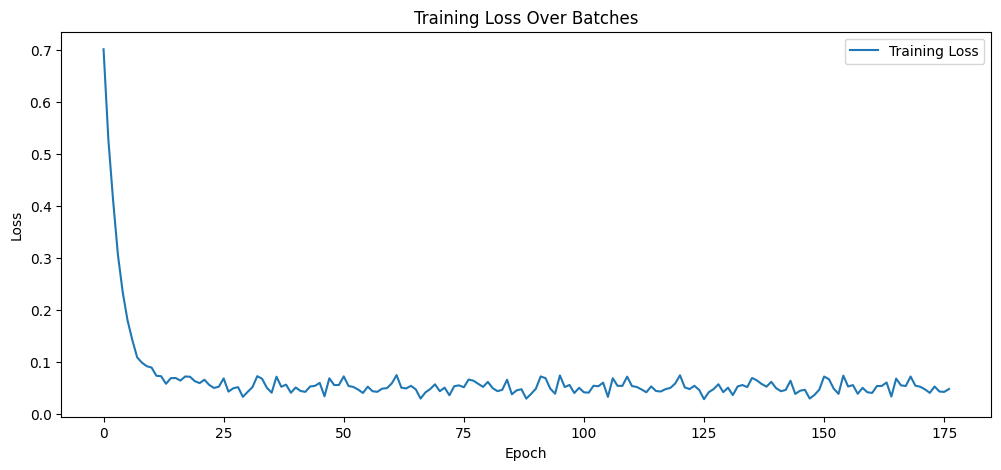

In [22]:
plt.figure(figsize=(12, 5))

plt.plot(loss_values, label='Training Loss')
plt.title('Training Loss Over Batches')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.show()

In [143]:
from sklearn.metrics import f1_score
import torch
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        outputs = model(**inputs)
        logits = outputs.logits

        probs = torch.sigmoid(logits)

        preds = (probs > 0.000005).int()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

In [144]:
all_preds_flat = all_preds
all_labels_flat = all_labels.reshape(all_preds.shape)

In [145]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

f1_micro = f1_score(all_labels_flat, all_preds_flat, average='micro')  # Calculate metrics globally by counting the total true positives, false negatives, and false positives
f1_macro = f1_score(all_labels_flat, all_preds_flat, average='macro')  # Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

print(f"F1 Score (Micro): {f1_micro}")
print(f"F1 Score (Macro): {f1_macro}")

accuracy = accuracy_score(all_labels_flat, all_preds_flat)
precision = precision_score(all_labels_flat, all_preds_flat, average='samples')
recall = recall_score(all_labels_flat, all_preds_flat, average='samples')

print(f"Accuracy: {accuracy}")
print(f"Precision (Samples Avg.): {precision}")
print(f"Recall (Samples Avg.): {recall}")

F1 Score (Micro): 0.018763833130963973
F1 Score (Macro): 0.018583955053691995
Accuracy: 0.0
Precision (Samples Avg.): 0.009470770544541702
Recall (Samples Avg.): 0.9090909090909091


C:\Users\arkad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [120]:
def mapLabels(labels_example):
    from ast import literal_eval
    labels = []
    with open("labels.txt", 'r', encoding='utf-8') as file:
        labels = [literal_eval(line) for line in file][0]
    return [name for index, name in enumerate(names) if labels_example[index] == 1]

sample_index = 1007
sample_text = dataset['text'][sample_index]
inputs = tokenizer(sample_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
labels_sample = list(dataset['labels'][sample_index][0])
encoded_list = mapLabels(labels_sample)


In [121]:
print("Encoded list:", encoded_list)

Encoded list: ['zwierzęta']


In [122]:
inputs.pop("token_type_ids", None)
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)

probs = torch.sigmoid(outputs.logits)
threshold = 0.5
predictions = (probs > threshold).int()

In [123]:
mapLabels(predictions.tolist()[0])

[]